In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data_utils
import time
import sklearn
from sklearn.metrics import confusion_matrix
from tqdm import tqdm, trange
import pandas as pd
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold,KFold

In [2]:
# read the file
df = pd.read_csv('communities.data', header=None)
print(df.shape)
df

(1994, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,?,?,TempleTerracecity,10,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,?,?,?,?,0.00,?,0.09
1990,6,?,?,Seasidecity,10,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,?,?,?,?,0.00,?,0.45
1991,9,9,80070,Waterburytown,10,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0,0.91,0.28,0.23
1992,25,17,72600,Walthamcity,10,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0,0.22,0.18,0.19


In [3]:
def virtual(series,tmp_list):
    return tmp_list.index(series)

In [4]:
# fill with the 0 value
df = df.replace("?",0)
# trun to the np.float32 if possible
for col in df.columns:
    try:
        df[col] = df[col].astype(np.float32)
    except:
        continue
df_feature = df.iloc[:,:-1]
df_class = df.iloc[:,-1:]
tmp_list = df_feature[3].unique().tolist()
# generate the virtual variable
df_feature[3] = df.apply(lambda x:virtual(x[3],tmp_list),axis = 1)
df_feature

,0,1,2,3,4,5,6,7,8,9,...,117,118,119,120,121,122,123,124,125,126
0,8.0,0.0,0.0,0,1.0,0.19,0.33,0.02,0.90,0.12,...,0.29,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14
1,53.0,0.0,0.0,1,1.0,0.00,0.16,0.12,0.74,0.45,...,0.00,0.02,0.12,0.45,0.00,0.00,0.00,0.0,0.00,0.00
2,24.0,0.0,0.0,2,1.0,0.00,0.42,0.49,0.56,0.17,...,0.00,0.01,0.21,0.02,0.00,0.00,0.00,0.0,0.00,0.00
3,34.0,5.0,81440.0,3,1.0,0.04,0.77,1.00,0.08,0.12,...,0.00,0.02,0.39,0.28,0.00,0.00,0.00,0.0,0.00,0.00
4,42.0,95.0,6096.0,4,1.0,0.01,0.55,0.02,0.95,0.09,...,0.00,0.04,0.09,0.02,0.00,0.00,0.00,0.0,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12.0,0.0,0.0,1823,10.0,0.01,0.40,0.10,0.87,0.12,...,0.00,0.01,0.28,0.05,0.00,0.00,0.00,0.0,0.00,0.00
1990,6.0,0.0,0.0,1824,10.0,0.05,0.96,0.46,0.28,0.83,...,0.00,0.02,0.37,0.20,0.00,0.00,0.00,0.0,0.00,0.00
1991,9.0,9.0,80070.0,1825,10.0,0.16,0.37,0.25,0.69,0.04,...,0.25,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28
1992,25.0,17.0,72600.0,1826,10.0,0.08,0.51,0.06,0.87,0.22,...,0.19,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18


In [5]:
# normalize the features and merge to data
df_feature = df_feature.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
df = pd.merge(df_feature,df_class,left_index=True,right_index=True)
df

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.127273,0.000000,0.000000,0.000000,0.0,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.945455,0.000000,0.000000,0.000547,0.0,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,0.00,0.00,0.00,0.0,0.00,0.00,0.67
2,0.418182,0.000000,0.000000,0.001095,0.0,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,0.00,0.00,0.00,0.0,0.00,0.00,0.43
3,0.600000,0.005952,0.860915,0.001642,0.0,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,0.00,0.00,0.00,0.0,0.00,0.00,0.12
4,0.745455,0.113095,0.064442,0.002189,0.0,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,0.00,0.00,0.00,0.0,0.00,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,0.200000,0.000000,0.000000,0.997811,1.0,0.01,0.40,0.10,0.87,0.12,...,0.01,0.28,0.05,0.00,0.00,0.00,0.0,0.00,0.00,0.09
1990,0.090909,0.000000,0.000000,0.998358,1.0,0.05,0.96,0.46,0.28,0.83,...,0.02,0.37,0.20,0.00,0.00,0.00,0.0,0.00,0.00,0.45
1991,0.145455,0.010714,0.846433,0.998905,1.0,0.16,0.37,0.25,0.69,0.04,...,0.08,0.32,0.18,0.08,0.06,0.78,0.0,0.91,0.28,0.23
1992,0.436364,0.020238,0.767466,0.999453,1.0,0.08,0.51,0.06,0.87,0.22,...,0.03,0.38,0.33,0.02,0.02,0.79,0.0,0.22,0.18,0.19


<AxesSubplot:>

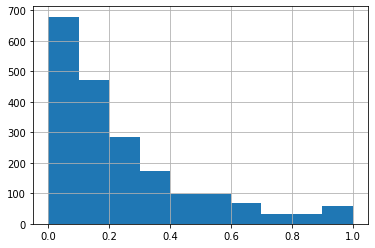

In [6]:
# plot the class(value)
df[127].hist()

In [7]:
# divide into 2 classes
def y_classify_2(series):
    if  series > 0.15:
        return 1
    else:
        return 0

In [8]:
# divide into 2 classes 
df_1 = df.copy()
df_1["class"] = df_1.apply(lambda x:y_classify_2(x[127]),axis = 1)
df_1 = df_1.drop([127],axis=1)

<AxesSubplot:>

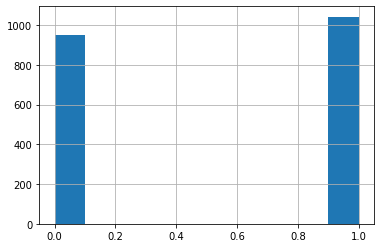

In [9]:
# plot
df_1["class"].hist()

In [10]:
# convert to tensor and store to the loader
# refer link: https://newbedev.com/convert-pandas-dataframe-to-pytorch-tensor
# set the data type and random
data = pd.DataFrame(df_1,dtype=np.float32)
data = sklearn.utils.shuffle(data)
data_train = data.iloc[:1800,:]
data_test = data.iloc[1800:,:]
print("data_train:",data_train.shape,"data_test:",data_test.shape)

data_list = []
for i in range(5):
    data_list.append(data.iloc[i:(i+1)*360,:])

data_train: (1800, 128) data_test: (194, 128)


In [11]:
# train loader
batch_size = 10
train_val_loader_list = []
for data_train in data_list:
    train_target = torch.tensor(data_train["class"].values.astype(np.float32))
    train_target = train_target.type(torch.LongTensor)
    train = torch.tensor(data_train.drop("class", axis = 1).values.astype(np.float32)) 
    train_tensor = data_utils.TensorDataset(train, train_target) 
    train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = False)
    train_val_loader_list.append(train_loader)

train_target = torch.tensor(data_train["class"].values.astype(np.float32))
train_target = train_target.type(torch.LongTensor)
train = torch.tensor(data_train.drop("class", axis = 1).values.astype(np.float32)) 
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = False)
# test loader
test_target = torch.tensor(data_test["class"].values.astype(int))
test_target = test_target.type(torch.LongTensor)
test = torch.tensor(data_test.drop("class", axis = 1).values.astype(np.float32)) 
test_tensor = data_utils.TensorDataset(test, test_target) 
test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = False)

# class labels
classes = ("high","low")
print(train.shape)

torch.Size([1796, 127])


### Conclusion with a function

In [12]:
def load_crime_data(file_path):
    df = pd.read_csv(file_path, header=None)
    # fill with the 0 value
    df = df.replace("?",0)
    # trun to the np.float32 if possible
    for col in df.columns:
        try:
            df[col] = df[col].astype(np.float32)
        except:
            continue
    df_feature = df.iloc[:,:-1]
    df_class = df.iloc[:,-1:]
    tmp_list = df_feature[3].unique().tolist()
    # generate the virtual variable
    df_feature[3] = df.apply(lambda x:virtual(x[3],tmp_list),axis = 1)
    df_feature
    # normalize the features and merge to data
    df_feature = df_feature.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    df = pd.merge(df_feature,df_class,left_index=True,right_index=True)
    # divide into 2 classes 
    df_1 = df.copy()
    df_1["class"] = df_1.apply(lambda x:y_classify_2(x[127]),axis = 1)
    df_1 = df_1.drop([127],axis=1)
    # convert to tensor and store to the loader
    # refer link: https://newbedev.com/convert-pandas-dataframe-to-pytorch-tensor
    # set the data type and random
    data = pd.DataFrame(df_1,dtype=np.float32)
    data = sklearn.utils.shuffle(data)
    data_train = data.iloc[:1800,:]
    data_test = data.iloc[1800:,:]
    print("data_train:",data_train.shape,"data_test:",data_test.shape)

    data_list = []
    for i in range(5):
        data_list.append(data.iloc[i:(i+1)*360,:])
    # train loader
    batch_size = 10
    train_val_loader_list = []
    for data_train in data_list:
        train_target = torch.tensor(data_train["class"].values.astype(np.float32))
        train_target = train_target.type(torch.LongTensor)
        train = torch.tensor(data_train.drop("class", axis = 1).values.astype(np.float32)) 
        train_tensor = data_utils.TensorDataset(train, train_target) 
        train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = False)
        train_val_loader_list.append(train_loader)

    train_target = torch.tensor(data_train["class"].values.astype(np.float32))
    train_target = train_target.type(torch.LongTensor)
    train = torch.tensor(data_train.drop("class", axis = 1).values.astype(np.float32)) 
    train_tensor = data_utils.TensorDataset(train, train_target) 
    train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = False)
    # test loader
    test_target = torch.tensor(data_test["class"].values.astype(int))
    test_target = test_target.type(torch.LongTensor)
    test = torch.tensor(data_test.drop("class", axis = 1).values.astype(np.float32)) 
    test_tensor = data_utils.TensorDataset(test, test_target) 
    test_loader = data_utils.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = False)

    # class labels
    classes = ("high","low")
    print(train.shape)
    return train_val_loader_list,test_loader

In [13]:
file_path = 'communities.data'
train_val_loader_list,testloader = load_crime_data(file_path)

data_train: (1800, 128) data_test: (194, 128)
torch.Size([1796, 127])


### Fully Connected Network Model Set

In [14]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(127, 254),
            nn.ReLU(),
            nn.Linear(254, 254),
            nn.ReLU(),
            nn.Linear(254, 2)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

net = NeuralNetwork()

In [15]:
# show the information of the NN
print("Model Information:",net)

Model Information: NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=127, out_features=254, bias=True)
    (1): ReLU()
    (2): Linear(in_features=254, out_features=254, bias=True)
    (3): ReLU()
    (4): Linear(in_features=254, out_features=2, bias=True)
  )
)


In [16]:
# visualize the layer,download the pdf
import torch
from torchviz import make_dot
x = torch.rand(10,127)
g = make_dot(net(x))
g.render('Q3_NN_Model', view=True)

'Q3_NN_Model.pdf'

In [17]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
# create the required list
loss_list = []
acc_list = []
loss_list_val = []
acc_list_val = []
interation_times = 0

In [19]:
# compute acc
def compute_acc(outputs, labels):
    max_list = []
    tmp_list = []
    _, predicted = torch.max(outputs, 1)
    max_list = predicted.tolist()
    for i in range(len(max_list)):
        if max_list[i] == labels[i]:
            tmp_list.append(1)
        else:
            tmp_list.append(0)
    return sum(tmp_list)/len(tmp_list)

In [20]:
epoch_num = 20
for epoch in tqdm(range(1,epoch_num+1)): 
    times = 0
    loss_val = 0; correct_val = 0; total = 0
    for load_num in range(len(train_val_loader_list)):
        trainloader = train_val_loader_list[load_num]
        for i, data in enumerate(trainloader, 0):
            times += 1
            # get the training data
            inputs, labels = data

            # initilize the parameter
            optimizer.zero_grad()

            # forward,backward and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        #validation
        tmplist1 = [0,1,2,3,4]
        tmplist1.remove(load_num)
        for valiload_num in tmplist1:
            valiload = train_val_loader_list[valiload_num]
            for data in valiload:
                images, labels = data
                outputs = net(images)
                loss_val += criterion(outputs, labels).item()
                correct_val += compute_acc(outputs, labels)
                total += 1

    loss_list_val.append([loss_val / total,epoch])
    acc_list_val.append([correct_val / total,epoch])
                
print('Finished Training')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:36<00:00,  1.82s/it]


Finished Training


Text(0.5, 1.0, 'cost for NN validation')

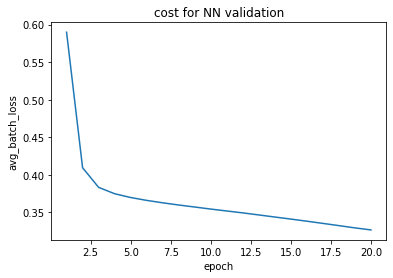

In [21]:
# draw the CNN validation cost
iteration_loss_list = loss_list_val

# draw plot 
plt.plot([x[1] for x in iteration_loss_list], [y[0] for y in iteration_loss_list])

# set the label of X and y
plt.xlabel("epoch")
plt.ylabel("avg_batch_loss")

# set the title of plot 
plt.title("cost for NN validation")

Text(0.5, 1.0, 'accuracy for NN validation')

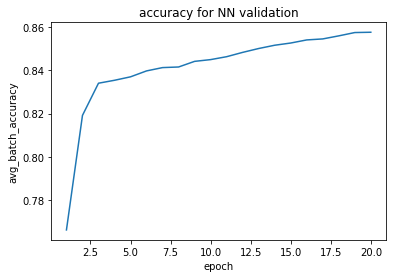

In [22]:
# draw the CNN validation acc
iteration_acc_list = acc_list_val

# draw plot 
plt.plot([x[1] for x in iteration_acc_list], [y[0] for y in iteration_acc_list])

# set the label of X and y
plt.xlabel("epoch")
plt.ylabel("avg_batch_accuracy")

# set the title of plot 
plt.title("accuracy for NN validation")

### Save Model

In [23]:
# save the model
torch.save(net.state_dict(), "Q3_NN.pth")
print("Saved")

Saved


### Load Saved Model

In [24]:
net = NeuralNetwork()
net.load_state_dict(torch.load("Q3_NN.pth"))

<All keys matched successfully>

### Test

In [25]:
# test all the test data
correct = 0
total = 0

for data in testloader:
    images, labels = data
    outputs = net(images)
    correct += compute_acc(outputs, labels)
    total += 1

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 79 %


In [26]:
# test all the test data based on differnt classification
# prepare to count predictions for each class
correct_pred = {_name: 0 for _name in classes}
total_pred = {_name: 0 for _name in classes}
y_true = []
y_pred = []

for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predictions = torch.max(outputs, 1)
    # collect the correct predictions for each class
    y_true += labels.tolist()
    y_pred += predictions.tolist()
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[classes[label]] += 1
        total_pred[classes[label]] += 1

# print accuracy for each classification
for _name, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[_name]
    print("Accuracy for class {:5s} is: {:.1f} %".format(_name,accuracy))

Accuracy for class high  is: 93.3 %
Accuracy for class low   is: 67.6 %


### Evaluation

In [27]:
# confusion matrix
def evaluation(y_true,y_pred,classes):
    judge = classification_report(y_true, y_pred,target_names=classes)
    print(judge)
    #confusion matrix
    classes = classes
    confusion = confusion_matrix(y_true, y_pred)
    plt.imshow(confusion, cmap=plt.cm.Greens)
    indices = range(len(confusion))
    plt.xticks(indices, classes)
    plt.yticks(indices, classes)
    plt.colorbar()
    plt.xlabel('y_pred')
    plt.ylabel('y_true')
    for first_index in range(len(confusion)):
        for second_index in range(len(confusion[first_index])):
            plt.text(first_index, second_index, confusion[first_index][second_index])
    plt.show()

              precision    recall  f1-score   support

        high       0.71      0.93      0.81        89
         low       0.92      0.68      0.78       105

    accuracy                           0.79       194
   macro avg       0.82      0.80      0.79       194
weighted avg       0.82      0.79      0.79       194



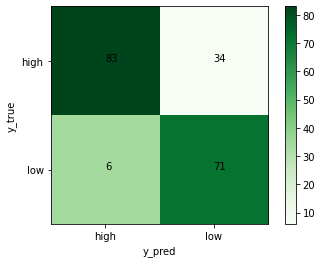

In [28]:
evaluation(y_true,y_pred,classes)